# Import Library

In [1]:
import pandas as pd
import numpy as np
from scipy import linalg as sp_linalg

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

Text(0.3, 0.3, '한글')

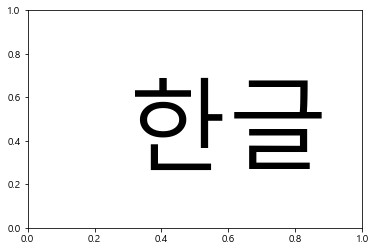

In [2]:
plt.text(0.3, 0.3, '한글', size=100)

# Import/Preprocess Datasets

In [3]:
df_new = pd.read_csv('filename.csv', encoding='cp949')
df_new.head()

,자전거번호,대여일시,대여대여소번호,대여대여소명,대여거치대,반납일시,반납대여소번호,반납대여소명,반납거치대,이용시간,이용거리
0,SPB-53145,2021-01-02 20:50:36,3,중랑센터,0,2021-01-02 21:15:41,668,서울축산농협(장안지점),0,25,0.00
1,SPB-53074,2021-01-04 16:02:12,3,중랑센터,0,2021-01-04 16:17:06,668,서울축산농협(장안지점),0,14,0.00
2,SPB-50952,2021-01-13 21:02:05,3,중랑센터,0,2021-01-13 21:14:04,668,서울축산농협(장안지점),0,11,1853.99
3,SPB-52380,2021-01-14 21:02:55,3,중랑센터,0,2021-01-14 21:13:41,668,서울축산농협(장안지점),0,10,0.00
4,SPB-52380,2021-01-18 18:02:08,3,중랑센터,0,2021-01-18 18:15:22,540,군자역 7번출구 베스트샵 앞,0,13,2291.05


## Delete unnecessary columns and split the time variable

In [4]:
df_new = df_new.drop(['자전거번호', '대여거치대', '반납거치대', '이용거리'], axis = 1)
df_new.head()

,대여일시,대여대여소번호,대여대여소명,반납일시,반납대여소번호,반납대여소명,이용시간
0,2021-01-02 20:50:36,3,중랑센터,2021-01-02 21:15:41,668,서울축산농협(장안지점),25
1,2021-01-04 16:02:12,3,중랑센터,2021-01-04 16:17:06,668,서울축산농협(장안지점),14
2,2021-01-13 21:02:05,3,중랑센터,2021-01-13 21:14:04,668,서울축산농협(장안지점),11
3,2021-01-14 21:02:55,3,중랑센터,2021-01-14 21:13:41,668,서울축산농협(장안지점),10
4,2021-01-18 18:02:08,3,중랑센터,2021-01-18 18:15:22,540,군자역 7번출구 베스트샵 앞,13


In [5]:
df_new['대여일시'] = pd.to_datetime(df_new['대여일시'])
df_new['반납일시'] = pd.to_datetime(df_new['반납일시'])

df_new['대여월'] = df_new['대여일시'].dt.month
df_new['대여일'] = df_new['대여일시'].dt.day
df_new['대여요일'] = df_new['대여일시'].dt.dayofweek
df_new['대여시간'] = df_new['대여일시'].dt.hour
df_new['대여시간_분'] = df_new['대여일시'].dt.minute

df_new['반납월'] = df_new['반납일시'].dt.month
df_new['반납일'] = df_new['반납일시'].dt.day
df_new['반납요일'] = df_new['반납일시'].dt.dayofweek
df_new['반납시간'] = df_new['반납일시'].dt.hour
df_new['반납시간_분'] = df_new['반납일시'].dt.minute

In [6]:
df_new = df_new.sort_values('대여일시', ignore_index = True)
df_new.head()

,대여일시,대여대여소번호,대여대여소명,반납일시,반납대여소번호,반납대여소명,이용시간,대여월,대여일,대여요일,대여시간,대여시간_분,반납월,반납일,반납요일,반납시간,반납시간_분
0,2021-01-01 00:00:01,2719,마곡문화공원,2021-01-01 00:15:26,2743,동신아파트 104동 앞,15,1,1,4,0,0,1,1,4,0,15
1,2021-01-01 00:00:10,670,삼육서울병원 버스정류장,2021-01-01 00:16:58,1405,망우역 1번출구,16,1,1,4,0,0,1,1,4,0,16
2,2021-01-01 00:00:23,1634,당고개공원 대여소,2021-01-01 00:12:30,1691,노원정보도서관,12,1,1,4,0,0,1,1,4,0,12
3,2021-01-01 00:00:33,1977,천왕역 1번 출입구 앞,2021-01-01 00:06:03,1952,천왕연지타운2단지 앞,5,1,1,4,0,0,1,1,4,0,6
4,2021-01-01 00:00:40,635,시조사 앞 (청량고정문 옆),2021-01-01 00:33:24,1320,LG베스트샵 종암점,32,1,1,4,0,0,1,1,4,0,33


## Rental Data
- Get Rent Count and define $\mu$
- $\mu$ = 10이면 15분동안 평균 10대의 자전거 대여

In [7]:
df_rental = df_new[['대여일시', '대여대여소명','대여대여소번호', '대여월', '대여일', '대여요일', '대여시간', '대여시간_분']]
df_rental.reset_index(drop = True, inplace = True)
df_rental.head(20)

,대여일시,대여대여소명,대여대여소번호,대여월,대여일,대여요일,대여시간,대여시간_분
0,2021-01-01 00:00:01,마곡문화공원,2719,1,1,4,0,0
1,2021-01-01 00:00:10,삼육서울병원 버스정류장,670,1,1,4,0,0
2,2021-01-01 00:00:23,당고개공원 대여소,1634,1,1,4,0,0
3,2021-01-01 00:00:33,천왕역 1번 출입구 앞,1977,1,1,4,0,0
4,2021-01-01 00:00:40,시조사 앞 (청량고정문 옆),635,1,1,4,0,0
5,2021-01-01 00:01:03,마곡나루역 3번 출구,2728,1,1,4,0,1
6,2021-01-01 00:01:13,혜화역 3번출구 뒤,341,1,1,4,0,1
7,2021-01-01 00:01:24,구의역 리버비스타 오피스텔,3570,1,1,4,0,1
8,2021-01-01 00:01:26,개봉역 1번 출구 자전거보관서쪽,1936,1,1,4,0,1
9,2021-01-01 00:01:29,길성그랑프리텔아파트,3772,1,1,4,0,1


In [8]:
df_rental2 = pd.DataFrame(df_rental[['대여대여소명','대여대여소번호','대여월','대여일','대여시간']].value_counts()).reset_index().rename(columns = {0 : 'rent_count'})
df_rental2['mu_15'] = df_rental2['rent_count'] / 4
df_rental2

,대여대여소명,대여대여소번호,대여월,대여일,대여시간,rent_count,mu_15
0,여의나루역 1번출구 앞,207,1,24,14,70,17.50
1,여의나루역 1번출구 앞,207,1,24,16,68,17.00
2,뚝섬유원지역 1번출구 앞,502,1,24,16,68,17.00
3,월드컵공원,186,1,24,15,63,15.75
4,여의나루역 1번출구 앞,207,1,24,15,63,15.75
...,...,...,...,...,...,...,...
452952,보문역6번출구 앞,1362,1,21,9,1,0.25
452953,보문역6번출구 앞,1362,1,21,8,1,0.25
452954,보문역6번출구 앞,1362,1,21,6,1,0.25
452955,보문역6번출구 앞,1362,1,20,23,1,0.25


## Return Data
- $\lambda$ : 평균도착률(15분당 자전거 반납수의 평균) 
- $\lambda$ = 10이면 15분동안 평균 10대의 자전거를 반납
- c: 최대거치용량
- return_count = r(t) : 관측된 자전거 반납수

In [9]:
df_return = df_new[['반납일시', '반납대여소명', '반납대여소번호','반납월', '반납일', '반납요일', '반납시간', '반납시간_분']]
df_return.reset_index(drop = True, inplace = True)

df_return.head()

,반납일시,반납대여소명,반납대여소번호,반납월,반납일,반납요일,반납시간,반납시간_분
0,2021-01-01 00:15:26,동신아파트 104동 앞,2743,1,1,4,0,15
1,2021-01-01 00:16:58,망우역 1번출구,1405,1,1,4,0,16
2,2021-01-01 00:12:30,노원정보도서관,1691,1,1,4,0,12
3,2021-01-01 00:06:03,천왕연지타운2단지 앞,1952,1,1,4,0,6
4,2021-01-01 00:33:24,LG베스트샵 종암점,1320,1,1,4,0,33


### Define Variables
- C as upper bound (Q3+IQR*1.5)
- Return count and Lambda

In [10]:
df_c = pd.DataFrame(df_return[['반납대여소명','반납대여소번호','반납월','반납일', '반납시간']].value_counts()).rename(columns = {0 : 'return_count'}).reset_index()
df_c.reset_index(drop=True, inplace = True)
df_c['lambda15'] = df_c['return_count']/4
df_c.columns = ['대여소명','대여소번호','월','일','시간','return_count','lambda15']

In [11]:
return_ubound = pd.DataFrame(df_c.groupby(['대여소명','대여소번호'])['return_count'].agg(lambda x : np.floor(np.percentile(x,75)+(np.percentile(x,75)-np.percentile(x,25))*1.5))).reset_index().rename(columns = {'return_count' : 'upperbound'})
return_ubound.head()

,대여소명,대여소번호,upperbound
0,(구)신한은행 중랑교지점,1442,3.0
1,(구)합정동 주민센터,101,3.0
2,(시립)고덕평생학습관,1070,1.0
3,(재)FITI시험연구원,2724,3.0
4,3호선 매봉역 3번출구앞,2335,3.0


### Merge Rental/Return DataFrame as one Dataset
- We can see that there are lots of NA values, cuased by non-existance of return/rent data at such TPO

In [12]:
df_rental2.columns = ['대여소명','대여소번호','월','일','시간','rent_count','mu_15']
df = pd.merge(df_c, df_rental2, on=['대여소명','대여소번호','월','일','시간'], how='outer')
df.tail(20)

,대여소명,대여소번호,월,일,시간,return_count,lambda15,rent_count,mu_15
651567,보문역6번출구 앞,1362,1,23,10,NaN,NaN,1.0,0.25
651568,보문역6번출구 앞,1362,1,23,9,NaN,NaN,1.0,0.25
651569,보문역6번출구 앞,1362,1,23,8,NaN,NaN,1.0,0.25
651570,보문역6번출구 앞,1362,1,19,12,NaN,NaN,1.0,0.25
651571,보문역6번출구 앞,1362,1,19,1,NaN,NaN,1.0,0.25
651572,보문역6번출구 앞,1362,1,18,23,NaN,NaN,1.0,0.25
651573,보문역6번출구 앞,1362,1,18,21,NaN,NaN,1.0,0.25
651574,보문역6번출구 앞,1362,1,18,18,NaN,NaN,1.0,0.25
651575,보문역6번출구 앞,1362,1,18,13,NaN,NaN,1.0,0.25
651576,보문역6번출구 앞,1362,1,18,11,NaN,NaN,1.0,0.25


### Create the base Dataframe
- So that there isn't any missed data in all station/days/time
- stops : unique station info (2281 rows)
- Dayhour : Time/days dataframe using repeat/tile function (24 * 31 rows as the sample data is of Jan)
- Dayhour_frame : combination of two dataframe(stops2, Dayhour) --> Total 2281* 31* 24 rows
- Combine the frame with the total datasets and fill na with 0

In [13]:
stops = df[['대여소명','대여소번호']].drop_duplicates().reset_index(drop=True)
Dayhour = pd.DataFrame({'월':np.repeat(1, 24*31*len(stops)),'일':np.repeat(np.arange(1,32), 24*len(stops)), '시간':np.tile(np.repeat(np.arange(24), len(stops)),31)})
stops2 = pd.concat([stops] * 24*31).reset_index(drop=True)
Dayhour_frame = pd.concat([stops2,Dayhour],axis=1)

In [14]:
df = pd.merge(df,Dayhour_frame, on = ['대여소명','대여소번호','월','일','시간'],how='outer')
df = pd.merge(df, return_ubound, on=['대여소명','대여소번호'], how='outer')
df.fillna(0, inplace=True)
df.tail(20)

,대여소명,대여소번호,월,일,시간,return_count,lambda15,rent_count,mu_15,upperbound
1628098,상암센터 정비실,5,1,31,4,0.0,0.0,0.0,0.0,0.0
1628099,상암센터 정비실,5,1,31,5,0.0,0.0,0.0,0.0,0.0
1628100,상암센터 정비실,5,1,31,6,0.0,0.0,0.0,0.0,0.0
1628101,상암센터 정비실,5,1,31,7,0.0,0.0,0.0,0.0,0.0
1628102,상암센터 정비실,5,1,31,8,0.0,0.0,0.0,0.0,0.0
1628103,상암센터 정비실,5,1,31,9,0.0,0.0,0.0,0.0,0.0
1628104,상암센터 정비실,5,1,31,10,0.0,0.0,0.0,0.0,0.0
1628105,상암센터 정비실,5,1,31,11,0.0,0.0,0.0,0.0,0.0
1628106,상암센터 정비실,5,1,31,12,0.0,0.0,0.0,0.0,0.0
1628107,상암센터 정비실,5,1,31,13,0.0,0.0,0.0,0.0,0.0


# Create Algorithm

## $\mu$, $\lambda$, and the basic probability

In [15]:
def mui(data,t) : 
  return(float(data['mu_15'][(data['시간']==t)]))


def lambdai(data, t) : 
  return(float(data['lambda15'][(data['시간']==t)]))

## Define Stochastic Matrix for the conditioned Probability
- We need to get this conditioned probability defined as below
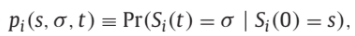
- Conditioned probability and Chapman-Kolmogorov Equations are defined as the picture below
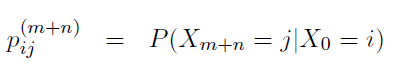
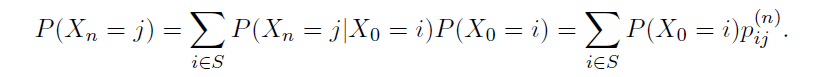

 Then, following the first and second definition & theorem, we can conclude that 
 
 $\ P( S(t) =  \sigma |  S(0) =s)$

= $\ P( S_{t+0} =  \sigma | S_{0} =s)$

= $\ P_{s,\sigma}^ {(t)} $

Thus, we need to get the stochastic matrix for the Markov chain.


### Calculate non conditional probability
To do this, we should first get the probability of each case(non-conditional), defined as below
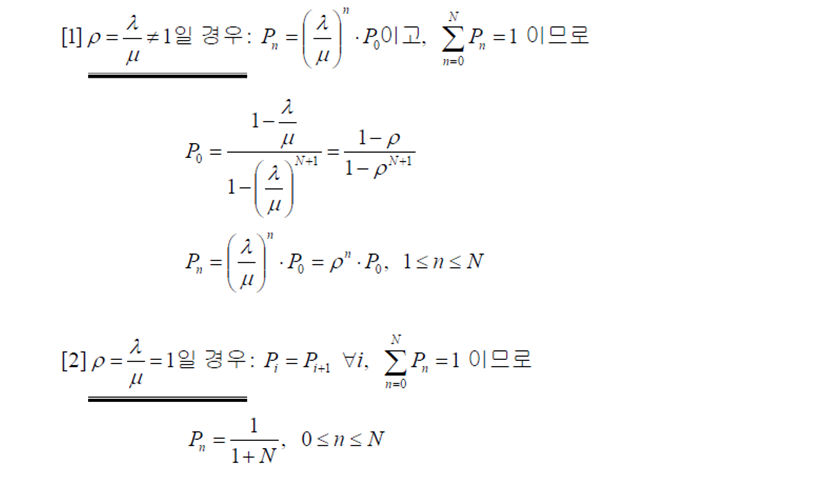


In [16]:
def ps(data,t, s) : 
  c = int(data['upperbound'][(data['시간']==1)])
  if mui(data,t) == 0 : 
    rho = 0
  else : 
    rho = lambdai(data,t)/mui(data,t) 
  if rho == 1 :
    p_s = 1/(1+c)
  else : 
    p0 = (1-rho)/(1-rho**(c+1))
    p_s = (rho**s)*p0
  return(p_s)

### Understanding The concept of the Markov chain for the station 

- To get the conditioned probablitiy, a Transition matrix for Markov chain should be defined but yet it's given.
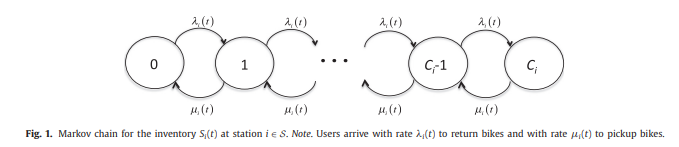

- As above, given thesis clearly mentions that the users arrive with rate $\lambda_i(t)$ to return bikes and with rate $\mu_i(t)$ to pickup bikes.
- This means a Time-inhomogeneous Markovian model of a station i, and hereby the Probability matrix equals Transition Rate matrix in Queueing theory, whose example is below. The first and last rows consists with $\mu$ and $\lambda$ each, and all the diagonal elements are $\lambda$, $-(\lambda+\mu)$ and $\mu$. All the rest elements are 0.
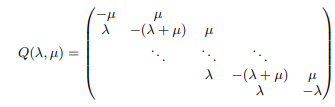

### Get the elements for the Transition rate matrix

- Hense, we need to define the transition rate matrix $Q(\lambda,\mu)$. As $\lambda$ and $\mu$ differ depending on time and station, we need to get the matrix for each hour, not only for the station. the number of zero in the matrix equals to the number of upperbound - 1. However, when the upperbound is 0, the matrix can't have element $\lambda$ or $\mu$. In this case, the matrix will be a 1*1 matrix with the element 0.

In [17]:
def create_mat(data, t) : 
  c = int(data['upperbound'][(data['시간']==1)])
  if c>=1 : 
    L = np.append([-mui(data,t),mui(data,t)],np.r_[np.tile(np.r_[(np.repeat(0,c-1),lambdai(data,t),-(lambdai(data,t)+mui(data,t)),mui(data,t))],c-1),np.repeat(0,c-1)]).tolist()
    L.append(lambdai(data,t))
    L.append(-lambdai(data,t))
    mat = np.matrix(np.reshape(L,(c+1,c+1)))
  else : 
    L = [0]
    mat = np.matrix(np.reshape(L,(1,1)))
  return(mat)

### Calculate the conditioned probability at a certain time.

- Another thesis define the conditioned probabaility using transition rate matrix is as below. By using the Kolmogorov equation, the probability that the station has y bikes at time t + h given that this station has x bikes at time t is:

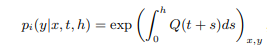

- $exp(M)$ is the matrix exponential of M and $\exp(M)_{x,y}$
is its term at row x and column y.

- We need to calculate $P_{i}(s, \sigma,t)$, which is the probability that the station has $\sigma$ bikes at time $t$ given that this station has $s$ bikes at time 0.
- Comparing those two formulas above, finally we need to calculate the expression below


## $\exp(\int^{t}_{0}Q(x)dx)_{s,\sigma}$

- We got the $Q(x)$ with create_mat. With scipy package, we can get the exponential form of matrix, which is in a matrix form as well. The conditioned probability we should get is the element in $s^{th}$ row and $\sigma^{th}$ column. 

In [18]:
def ps_cond(data,t, s, sigma) : 
  mat = create_mat(data,t)
  c = int(data['upperbound'][(data['시간']==1)])
  mat2 = sp_linalg.expm(mat)
  prob = mat2[s,sigma]
  return(prob)

### An image file FYI

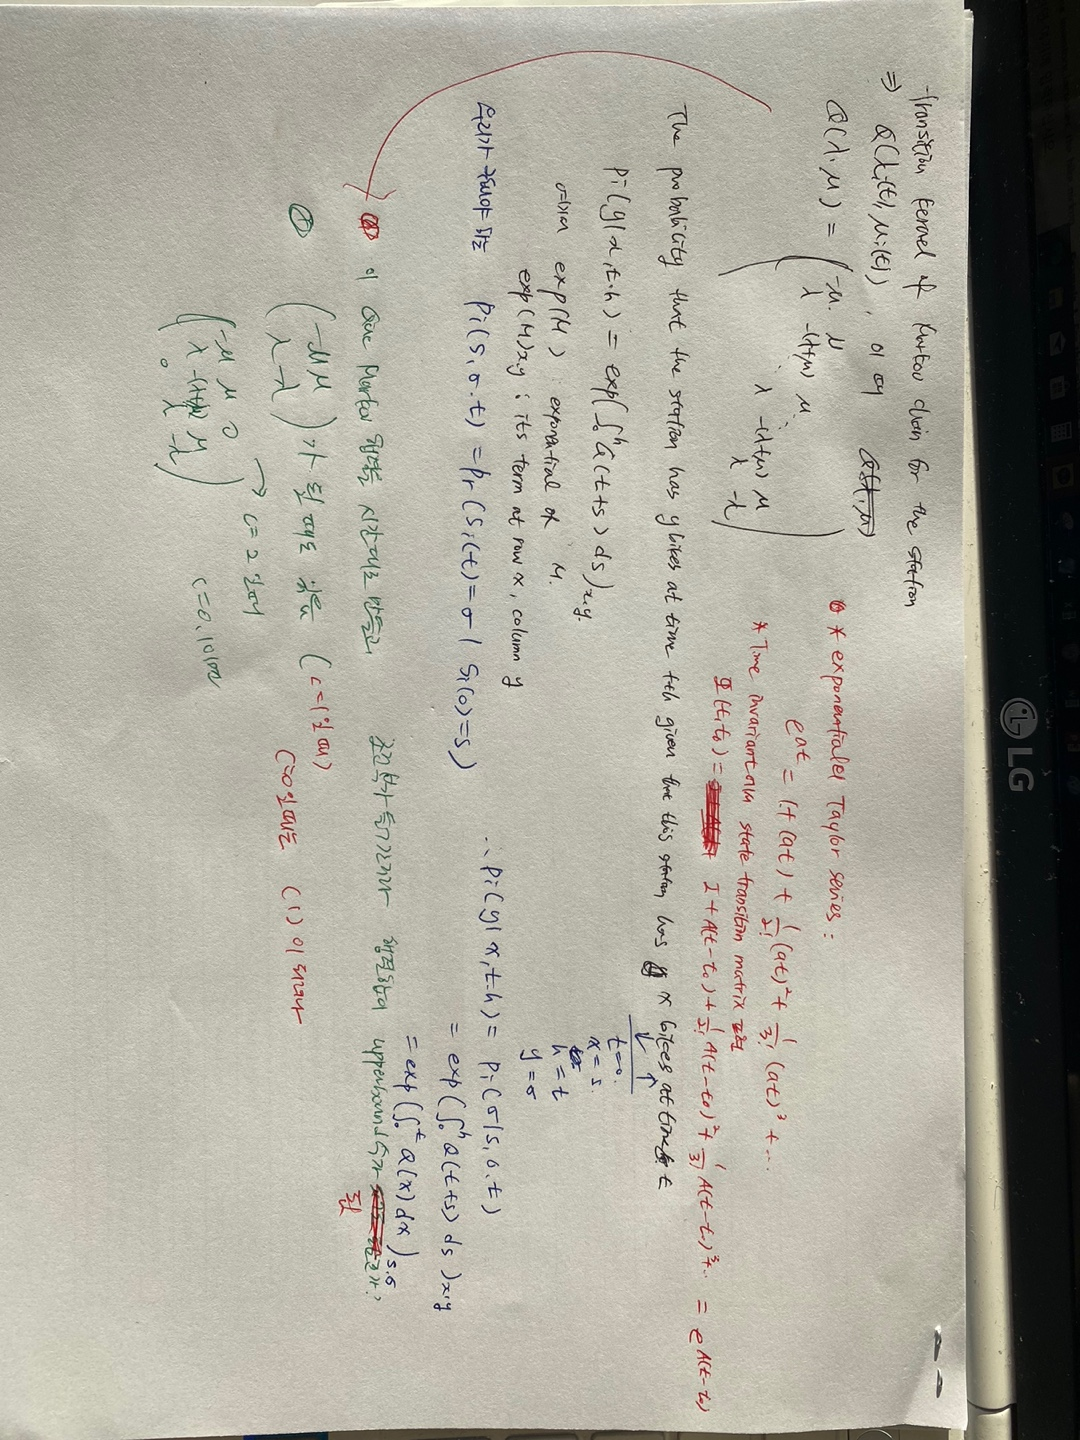


## Define Expected values of bike pickup/return demands
- Now we can calculate the expected values of bike pickup/return demands, expressed as e_satisfied
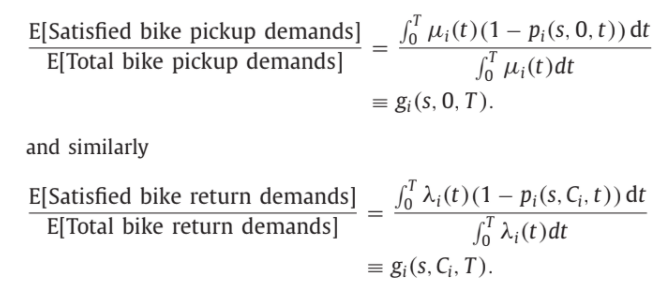

In [19]:
def e_satisfied(data,t,s,returnpickup) :
  c = int(data['upperbound'][(data['시간']==1)])
  if returnpickup == "pickup" :
    prob = mui(data,t)*(1-ps_cond(data,t,s,0))
  elif returnpickup == "return" : 
    prob = lambdai(data,t)*(1-ps_cond(data,t,s,c))
  return(prob)


## Calculate expected values using Integral or sigma
- Although the equation is expressed as continuous variable, as Time is descrete with the range of (0,1,2,...,23) we'll calculate it with sigma, not integral

In [20]:
def lemma1(data,t,s,returnpickup) :
  bunja = 0
  bunmo = 0
  for time in range(t+1) : 
    bunja += e_satisfied(data,time,s,returnpickup)
    if returnpickup =='pickup' : 
      bunmo += mui(data,time)
    elif returnpickup =='return':
      bunmo += lambdai(data,time)
  
  if bunmo == 0 :
    return(0)
  else : 
    return(bunja/bunmo)

## Calculate the min/max value of station inventory
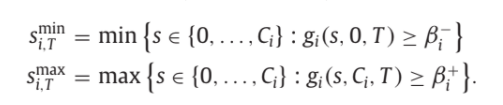

- To calculate this we'll need to see which \s in range($[0,C_{i}]$) is greater than the beta prob. 
- For the faster calculation, the original dataframe will be cropped according to the parameter i, month, day

In [21]:
def sminmax(i,month,day,t, beta) : 
  L1=[]
  L2=[]
  data = df[(df['대여소번호']==i)&(df['월']==month)&(df['일']==day)].reset_index()
  c = int(data['upperbound'][(data['시간']==1)])
  for a in range(c+1) : 
    if lemma1(data,t,a,"pickup") >= beta :
      L1.append(a)
    if lemma1(data,t,a,"return") >= beta : 
      L2.append(a)
  
  if len(L1) == 0 : 
    a = '값없음'
  elif len(L1) > 0 :
    a = min(L1)
  if len(L2) == 0 : 
    b = '값없음'
  elif len(L2) > 0 :
    b = max(L2)
  return(a,b)

# Verification with some examples

In [22]:
sminmax(1210,1,10,17,0.85)

(2, 11)

In [23]:
sminmax(502,1,24,6,0.85)

(3, 13)

## Verification with the date 24th of Jan

- Will verify if all of the function works perfectly.
- The sum of conitioned probability equals to $c+1$ (number of upperbound + 1), as the sum of conditioned probability given that the station has $s$ bikes at time 0 is 1 and $s \in [0,C_{i}]$

In [24]:
sample_df = pd.DataFrame(columns = ['Station','Month','Date', 'Time','beta','sminmax','ubound','sum_pscond'])                  

In [ ]:
for station in set(df['대여소번호']):
    data = df[(df['대여소번호']==station)&(df['월']==1)&(df['일']==24)].reset_index()
    c= int(data['upperbound'][(data['시간']==1)])
    for time in range(24) : 
        answer = []
        for s in range(int(data['upperbound'][(data['시간']==1)])+1):
            for sigma in range(int(data['upperbound'][(data['시간']==1)])+1):
                answer.append(ps_cond(data, 0, s, sigma))
        #sample_df['Station'].append(station)
        #sample_df['Month'].append(1)
        #sample_df['Date'].append(24)
        #sample_df['Time'].append(time)
        #sample_df['beta'].append(0.85)
        #sample_df['sminmax'].append(sminmax(station,1,24,time,0.85))
        #sample_df['ubound'] = df['upperbound'][(df['대여소번호']==i)&(df['월']==month)&(df['일']==day)&(df['시간']==time)]
        sample_df = sample_df.append({'Station' : station , 'Month' : 1, 'Date' : 24,'Time' : time,'beta' : 0.85,'sminmax' : sminmax(station,1,24,time,0.85),'ubound' : int(df['upperbound'][(df['대여소번호']==station)&(df['월']==1)&(df['일']==24)&(df['시간']==time)]),'sum_pscond' :sum(answer) } , ignore_index=True)

In [ ]:
sample_df

In [ ]:
sample_df.to_csv('sample_df2.csv', encoding='cp949')